# Planet: Understanding the Amazon deforestation from Space challenge

This notebook relays on all the work done by  [EKami](https://github.com/EKami/planet-amazon-deforestation) for the [Planet: Understanding the Amazon from Space](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space)  Kaggle competition

## Import required modules

In [2]:
import os
import gc
#import bcolz
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
from keras.models import load_model
import vgg16
import data_helper
from data_helper import AmazonPreprocessor
from PIL import Image
#from kaggle_data.downloader import KaggleDataDownloader

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/root/anaconda3/envs/amazon_deforestation_2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:455: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/root/anaconda3/envs/amazon_deforestation_2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:456: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/root/anaconda3/envs/amazon_deforestation_2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:457: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/root/anaconda3/env

Print tensorflow version for reuse (the Keras module is used directly from the tensorflow framework)

In [3]:
tf.__version__

'1.1.0'

## Inspect image labels
Visualize what the training set looks like

In [3]:
train_jpeg_dir, test_jpeg_dir, test_jpeg_additional, train_csv_file = data_helper.get_jpeg_data_files_paths()
labels_df = pd.read_csv(train_csv_file)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


Each image can be tagged with multiple tags, lets list all uniques tags

In [4]:
# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))

There is 17 unique labels including {'slash_burn', 'water', 'habitation', 'partly_cloudy', 'road', 'artisinal_mine', 'cultivation', 'bare_ground', 'clear', 'conventional_mine', 'haze', 'selective_logging', 'primary', 'agriculture', 'cloudy', 'blooming', 'blow_down'}


### Repartition of each labels

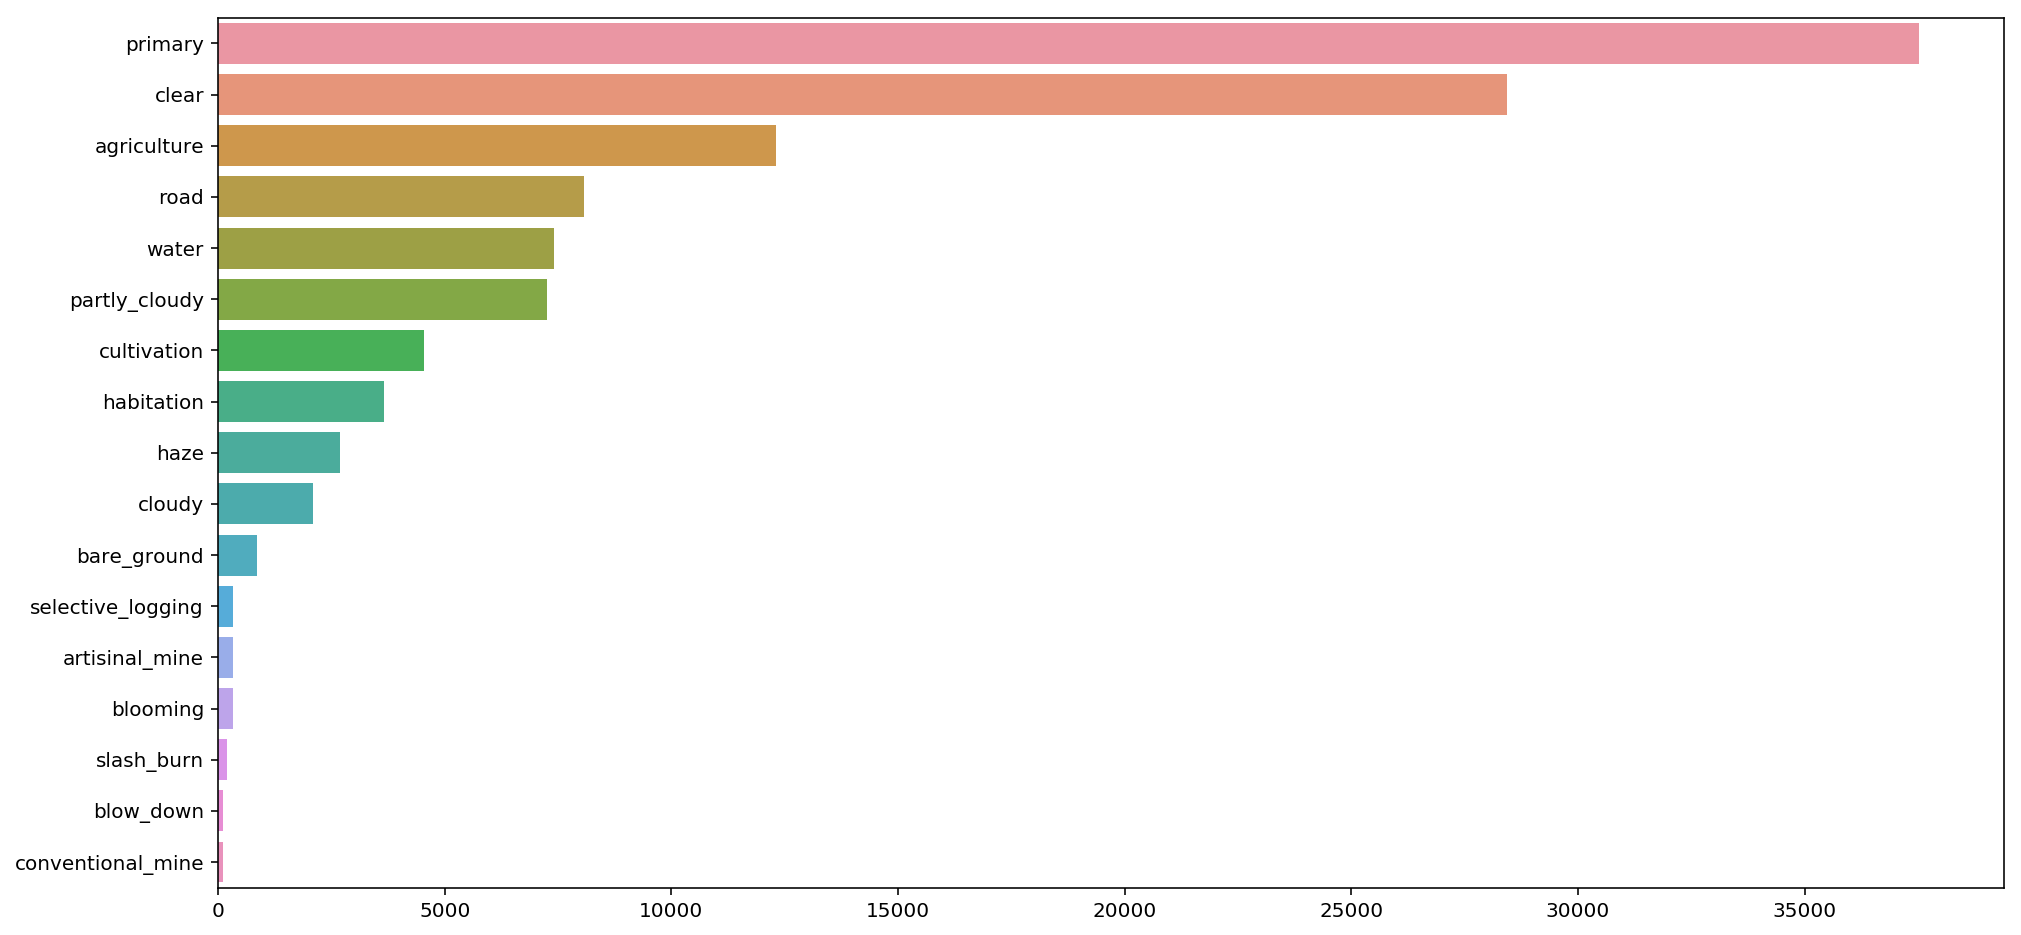

In [6]:
# Histogram of label instances
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

## Images
Visualize some chip images to know what we are dealing with.
Lets vizualise 1 chip for the 17 images to get a sense of their differences.

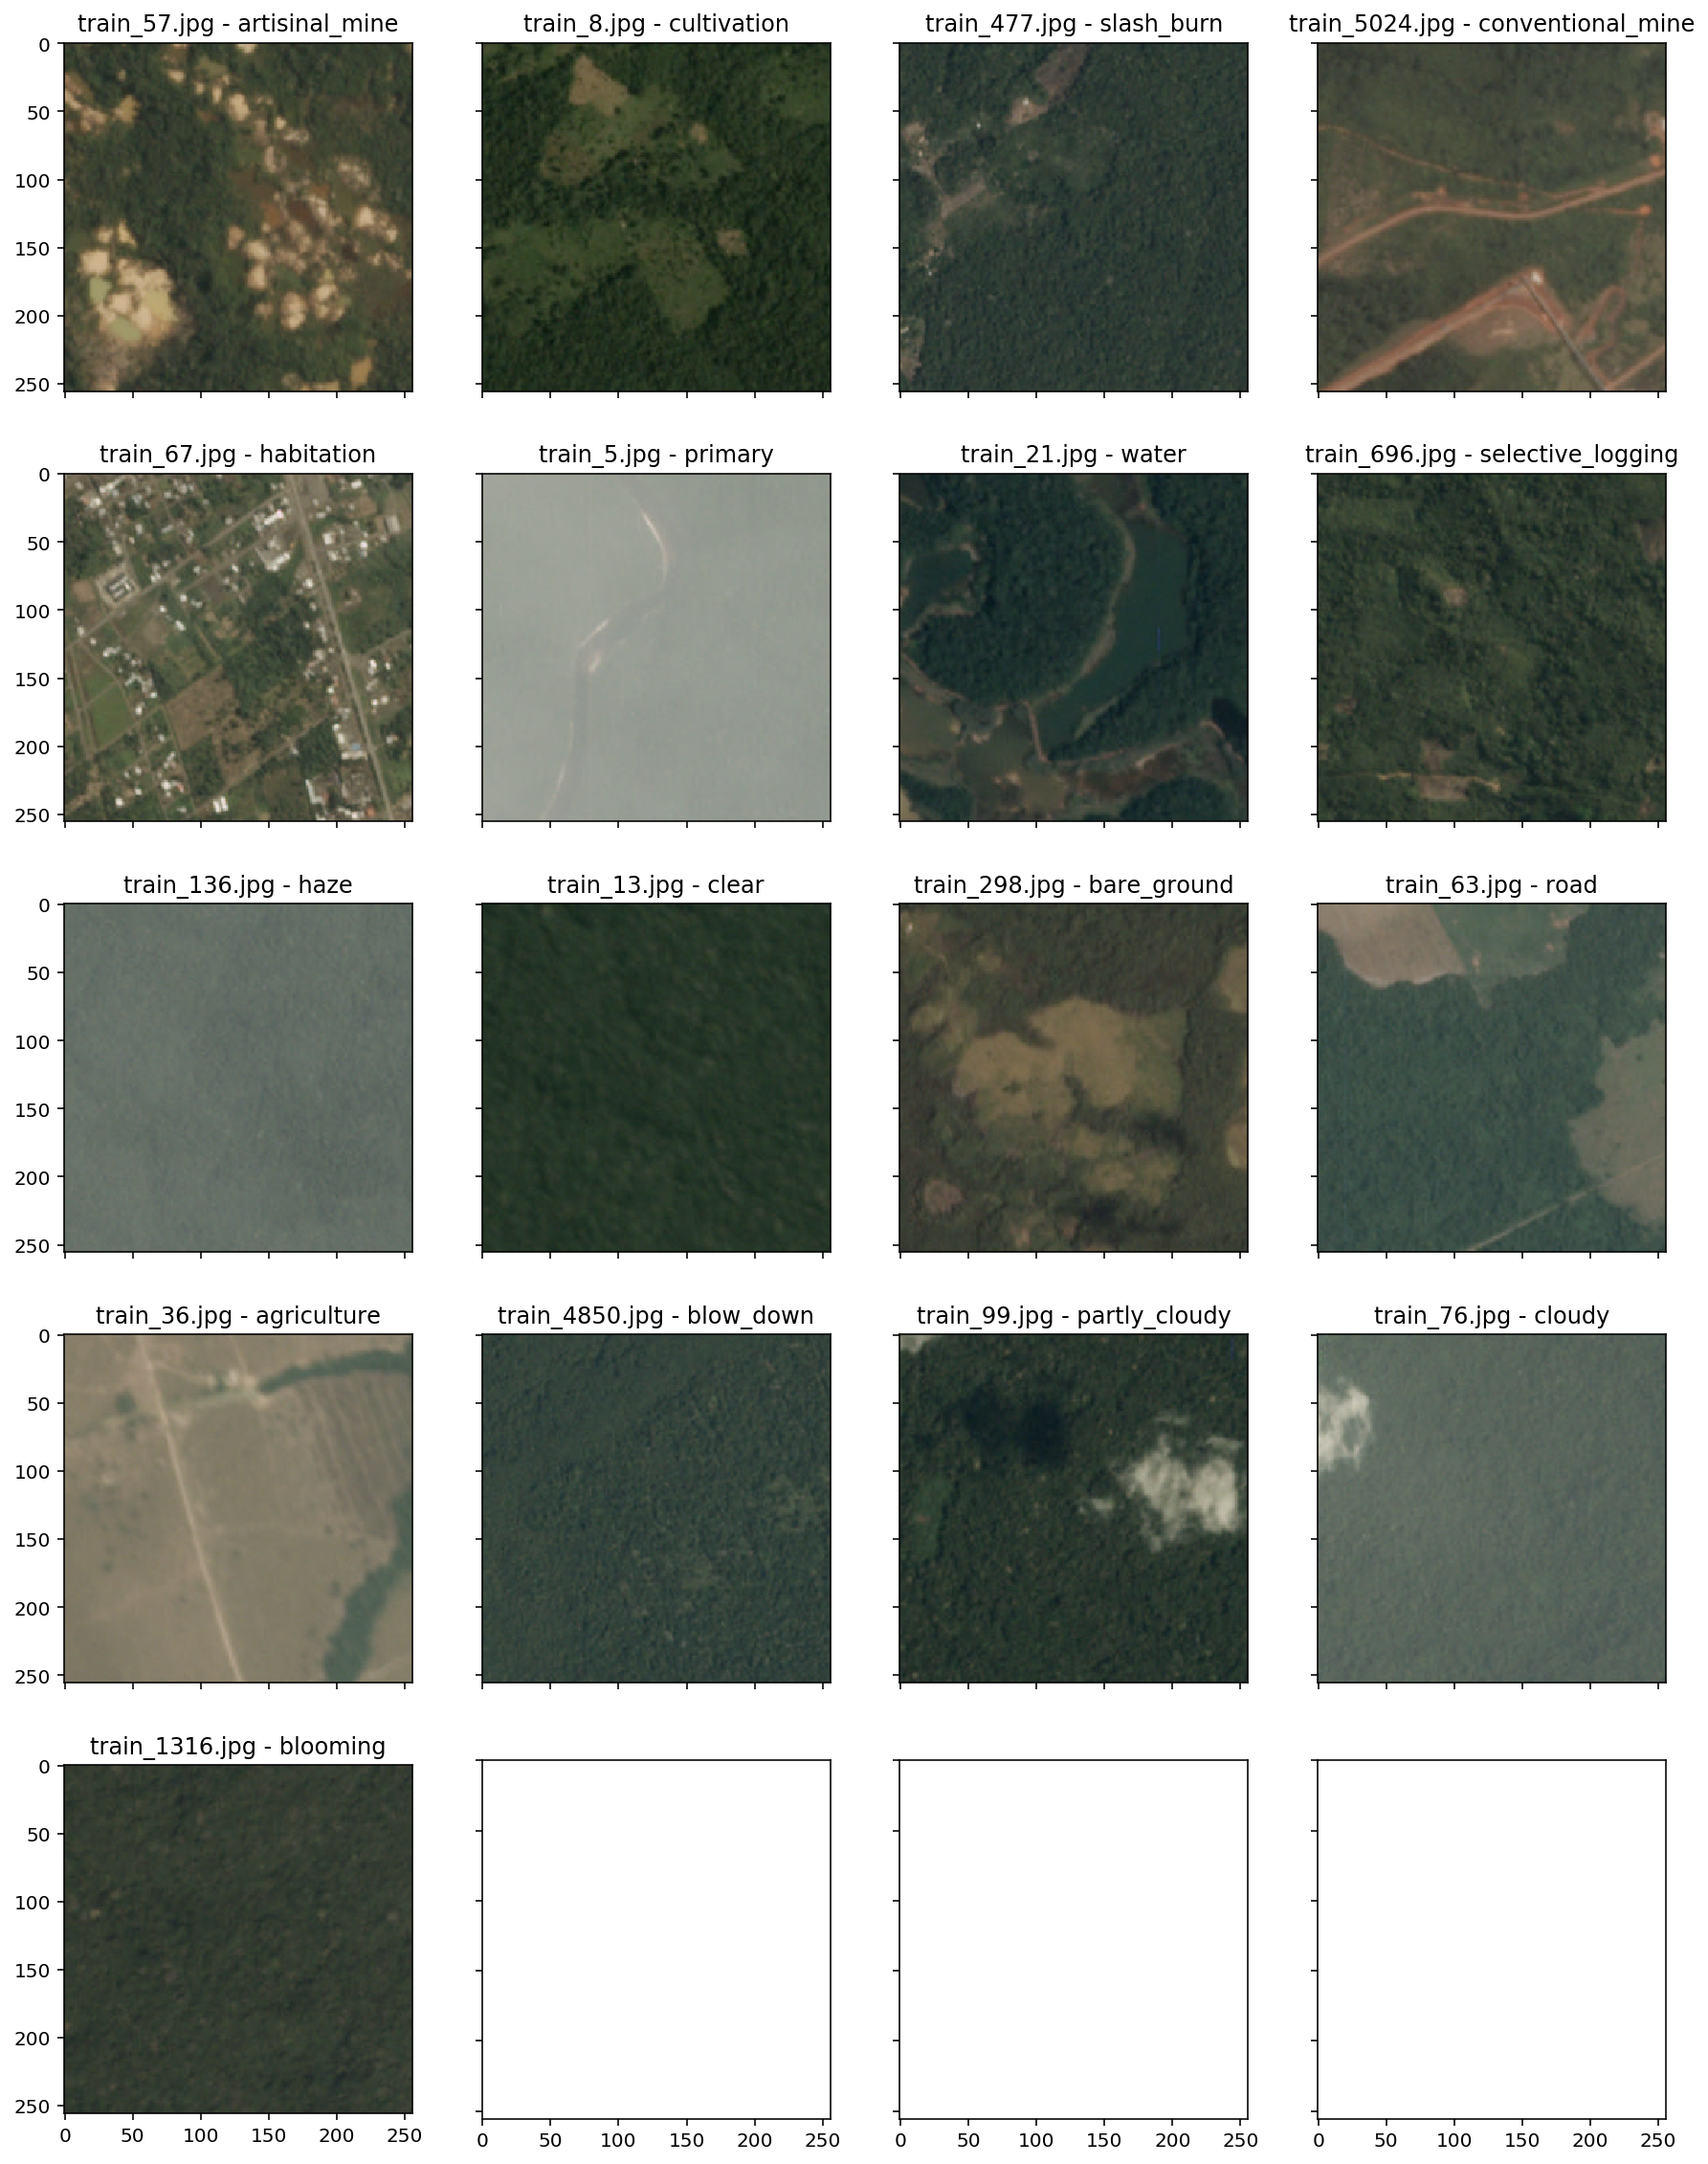

In [7]:
images_title = [labels_df[labels_df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' 
                for i, label in enumerate(labels_set)]

plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for i, (image_name, label) in enumerate(zip(images_title, labels_set)):
    img = mpimg.imread(train_jpeg_dir + '/' + image_name)
    axs[i].imshow(img)
    axs[i].set_title('{} - {}'.format(image_name, label))

# Image resize & validation split
Define the dimensions of the image data trained by the network. Recommended resized images could be 32x32, 64x64, or 128x128 to speedup the training. 

You could also use `None` to use full sized images.

Be careful, the higher the `validation_split_size` the more RAM you will consume.

In [8]:
img_resize = (128, 128) # The resize size of each image ex: (64, 64) or None to use the default image size
validation_split_size = 0.2

# Data preprocessing
Due to the hudge amount of memory the preprocessed images can take, we will create a dedicated `AmazonPreprocessor` class which job is to preprocess the data right in time at specific steps (training/inference) so that our RAM don't get completely filled by the preprocessed images. 

The only exception to this being the validation dataset as we need to use it as-is for f2 score calculation as well as when we calculate the validation accuracy of each batch.

In [9]:
preprocessor = AmazonPreprocessor(train_jpeg_dir, train_csv_file, test_jpeg_dir, test_jpeg_additional, 
                                  img_resize, validation_split_size)
preprocessor.init()

100%|██████████| 8096/8096 [00:00<00:00, 108982.12it/s]


Transforming val dataset...


100%|██████████| 8096/8096 [00:22<00:00, 365.77it/s]


Done. Size consumed by validation matrices 1518.0 mb


In [10]:
print("X_train/y_train length: {}/{}".format(len(preprocessor.X_train), len(preprocessor.y_train)))
print("X_val/y_val length: {}/{}".format(len(preprocessor.X_val), len(preprocessor.y_val)))
print("X_test/X_test_filename length: {}/{}".format(len(preprocessor.X_test), len(preprocessor.X_test_filename)))
preprocessor.y_map

X_train/y_train length: 32383/32383
X_val/y_val length: 8096/8096
X_test/X_test_filename length: 61191/61191


{0: 'agriculture',
 1: 'artisinal_mine',
 2: 'bare_ground',
 3: 'blooming',
 4: 'blow_down',
 5: 'clear',
 6: 'cloudy',
 7: 'conventional_mine',
 8: 'cultivation',
 9: 'habitation',
 10: 'haze',
 11: 'partly_cloudy',
 12: 'primary',
 13: 'road',
 14: 'selective_logging',
 15: 'slash_burn',
 16: 'water'}

# Funetuning

Here we define the model for finetuning

In [11]:
model = vgg16.create_model(img_dim=(128, 128, 3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                139281    
Total params: 14,853,981
Trainable params: 14,853,975
Non-trainable params: 6
_________________________________________________________________


## Fine-tune conv layers
We will now finetune all layers in the VGG16 model. 

In [13]:
history = History()
callbacks = [history, 
             EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
             ModelCheckpoint(filepath='weights/weights.best.hdf5', verbose=1, save_best_only=True, 
                             save_weights_only=True, mode='auto')]

X_train, y_train = preprocessor.X_train, preprocessor.y_train
X_val, y_val = preprocessor.X_val, preprocessor.y_val

batch_size = 128
train_generator = preprocessor.get_train_generator(batch_size)
steps = len(X_train) / batch_size

model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics = ['accuracy'])
#previous epochs=25
history = model.fit_generator(train_generator, steps, epochs=2, verbose=1, 
                    validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/2
253/252 [==============================] - 22493s 89s/step - loss: 0.1110 - acc: 0.9582 - val_loss: 0.1030 - val_acc: 0.9606

Epoch 00001: val_loss improved from inf to 0.10300, saving model to weights/weights.best.hdf5
Epoch 2/2
253/252 [==============================] - 23129s 91s/step - loss: 0.1000 - acc: 0.9619 - val_loss: 0.0965 - val_acc: 0.9638

Epoch 00002: val_loss improved from 0.10300 to 0.09651, saving model to weights/weights.best.hdf5


## Visualize Loss Curve

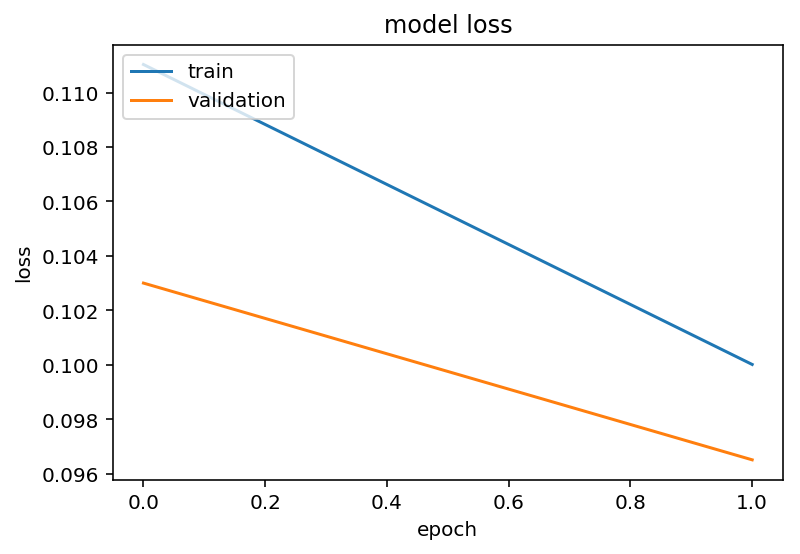

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Load Best Weights

In [15]:
model.load_weights("weights/weights.best.hdf5")
print("Weights loaded")

Weights loaded


In [16]:
model.save('vgg16_trained.h5')
print("Model Saved")

Model Saved


## Check Fbeta Score

In [17]:
fbeta_score = vgg16.fbeta(model, X_val, y_val)

fbeta_score

0.9187271986160227

## Make predictions

In [18]:
predictions, x_test_filename = vgg16.predict(model, preprocessor, batch_size=128)
print("Predictions shape: {}\nFiles name shape: {}\n1st predictions ({}) entry:\n{}".format(predictions.shape, 
                                                                              x_test_filename.shape,
                                                                              x_test_filename[0], predictions[0]))

479/478 [==============================] - 14691s 31s/step
Predictions shape: (61191, 17)
Files name shape: (61191,)
1st predictions (test_30783) entry:
[9.4866228e-01 3.3865614e-05 1.1606612e-03 2.1393271e-05 3.8839440e-05
 1.1419082e-02 9.9796589e-06 4.4563032e-05 1.0684617e-01 2.9960183e-02
 6.2589017e-03 9.9127543e-01 9.9881941e-01 9.6677947e-01 2.4981680e-04
 3.3021711e-03 3.0534524e-01]


Before mapping our predictions to their appropriate labels we need to figure out what threshold to take for each class

In [16]:
thresholds = [0.2] * len(labels_set)

Now lets map our predictions to their tags by using the thresholds

In [19]:
predicted_labels = vgg16.map_predictions(preprocessor, predictions, thresholds)

Finally lets assemble and visualize our predictions for the test dataset to run batch predictions

In [20]:
tags_list = [None] * len(predicted_labels)
for i, tags in enumerate(predicted_labels):
    tags_list[i] = ' '.join(map(str, tags))

final_data = [[filename.split(".")[0], tags] for filename, tags in zip(x_test_filename, tags_list)]

In [21]:
final_df = pd.DataFrame(final_data, columns=['image_name', 'tags'])
print("Predictions rows:", final_df.size)
final_df.head()

Predictions rows: 122382


,image_name,tags
0,test_1205,clear primary
1,test_22307,agriculture clear primary road
2,test_4754,agriculture clear habitation primary water
3,test_11505,agriculture clear primary road water
4,test_27991,clear primary


## Test 

## Reload Model and Test Single Predictions

In [5]:
new_model = load_model('vgg16_trained.h5')
# Show the model architecture
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                139281    
Total params: 14,853,981
Trainable params: 14,853,975
Non-trainable params: 6
_________________________________________________________________


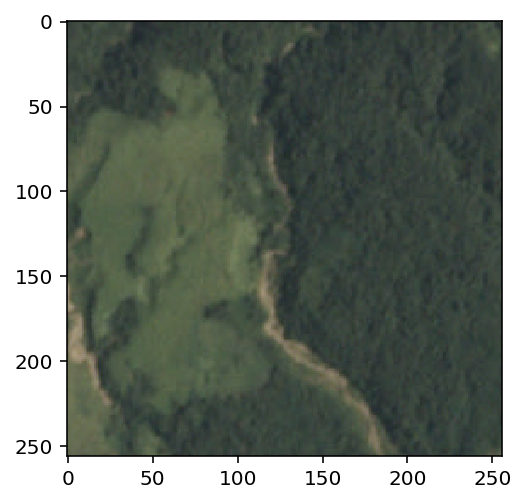

In [6]:
image_name = 'train_1.jpg'
img = mpimg.imread(train_jpeg_dir + '/' + image_name)
plt.imshow(img)

In [7]:
img_reshape = np.expand_dims(img, axis=0) 

In [8]:
import cv2
img_reshape = np.asarray(Image.fromarray(img).convert("RGB"), dtype=np.float32)
img_reshape = cv2.resize(src = img_reshape, dsize=(128, 128))
img_reshape = np.expand_dims(img_reshape, axis=0) 
img_reshape.shape

(1, 128, 128, 3)

In [46]:
prediction = new_model.predict(img_reshape)

In [52]:
labels = list(labels_set)
results = prediction[0] > 0.2
true_index_values = [i for i, x in enumerate(results) if x]
tags_results = [labels[x] for x in true_index_values]

In [53]:
tags_results

['slash_burn',
 'water',
 'selective_logging',
 'primary',
 'agriculture',
 'blow_down']